In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import string
from itertools import product
from numpy.random import normal, exponential, seed

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=UserWarning)

In [3]:
gg.theme_set(gg.theme_minimal())

In [4]:
RANDOM_SEED = 103

---

## Model 6. Varying intercept and slope.

Model the logFC for knocking-out a gene $g$ with sgRNA $s$ with known copy number $X$.
Use a varying intercept for the the intercept and slope by taget gene $g$ of the sgRNA $s$.

$
logFC_s \sim \mathcal{N}(\mu_s, \sigma) \\
\mu_s = \alpha_s + \beta_s X \\
\quad \alpha_s \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha = \gamma_g \\
\qquad\quad \gamma_g \sim \mathcal{N}(\mu_\gamma, \sigma_\gamma) \\
\qquad\qquad \mu_\gamma \sim \mathcal{N}(0, 5) \quad \sigma_\gamma \sim \text{Exp}(1) \\
\qquad \sigma_\alpha \sim \text{Exp}(1) \\
\quad \beta_s \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \mu_\beta = \delta_g \\
\qquad\quad \delta_g \sim \mathcal{N}(\mu_\delta, \sigma_\delta) \\
\qquad\qquad \mu_\delta \sim \mathcal{N}(0, 5) \quad \sigma_\delta \sim \text{Exp}(1) \\
\qquad \sigma_\beta \sim \text{Exp}(1) \\
\sigma \sim \text{Exp}(1)
$

Simulated values:

- number of cell lines: 20
- number of genes: 5
- number of repeated measures: ${1, 2, 3, 4, 5}$
- $\mu_\gamma = -0.5$, $\sigma_\gamma = 0.5$
- $\sigma_\alpha = 0.2$
- $\mu_\delta = -1$, $\sigma_\delta = 1$
- $\sigma_\beta = 0.2$
- $\sigma = 0.3$

In [80]:
seed(RANDOM_SEED)

num_cell_lines = 20
num_genes = 5
num_sgrna_per_gene = list(range(1, num_genes + 1))
num_sgrnas = sum(num_sgrna_per_gene)

real_params = {
    "mu_gamma": -0.5,
    "sigma_gamma": 0.5,
    "sigma_alpha": 0.2,
    "mu_delta": -1,
    "sigma_delta": 1,
    "sigma_beta": 0.2,
    "sigma": 0.3,
}


def prefix_num(prefix, n):
    return [prefix + str(i) for i in range(n)]


cell_lines = prefix_num("cell_", num_cell_lines)
genes = prefix_num("gene_", num_genes)
sgrnas = prefix_num("sgRNA_", num_sgrnas)

real_params["gamma_g"] = normal(
    real_params["mu_gamma"], real_params["sigma_gamma"], num_genes
)
real_params["mu_alpha"] = real_params["gamma_g"]
real_params["delta_g"] = normal(
    real_params["mu_delta"], real_params["sigma_delta"], num_genes
)
real_params["mu_beta"] = real_params["delta_g"]


real_alpha_s = []
real_beta_s = []
for gene_i in range(num_genes):
    mu_alpha = real_params["mu_alpha"][gene_i]
    mu_beta = real_params["mu_beta"][gene_i]
    for sgrna_j in range(num_sgrna_per_gene[gene_i]):
        real_alpha_s.append(normal(mu_alpha, real_params["sigma_alpha"]))
        real_beta_s.append(normal(mu_beta, real_params["sigma_beta"]))

real_params["alpha_s"] = real_alpha_s
real_params["beta_s"] = real_beta_s

gene_to_sgrna_map = pd.DataFrame(
    {"gene": np.repeat(genes, num_sgrna_per_gene), "sgRNA": sgrnas}
)
gene_to_sgrna_map["gene"] = pd.Categorical(gene_to_sgrna_map["gene"], categories=genes)
gene_to_sgrna_map["sgRNA"] = pd.Categorical(
    gene_to_sgrna_map["sgRNA"], categories=sgrnas
)

data = pd.DataFrame(product(genes, cell_lines), columns=["gene", "cell_line"])
data = pd.merge(data, gene_to_sgrna_map, how="right", on="gene")
data["cell_line"] = pd.Categorical(data["cell_line"], categories=cell_lines)
data["gene"] = pd.Categorical(data["gene"], categories=genes)
data["sgRNA"] = pd.Categorical(data["sgRNA"], categories=sgrnas)

gene_lambdas = [1, 0.8, -1, 1.5, 2]

data["logfc"] = np.nan
data["cna"] = np.nan

for i in range(len(data)):
    gene_i = data.gene.cat.codes[i]
    sgrna_i = data.sgRNA.cat.codes[i]

    alpha_s = real_params["alpha_s"][sgrna_i]
    beta_s = real_params["beta_s"][sgrna_i]

    gene_cna_lambda = gene_lambdas[gene_i]
    cna = -1
    if gene_cna_lambda == -1:
        cna = 2
    else:
        cna = np.random.poisson(lam=gene_cna_lambda)

    cna = np.max([cna + normal(0, 0.1, 1), 0])
    mu_s = alpha_s + beta_s * cna
    data.loc[i, "cna"] = cna
    data.loc[i, "logfc"] = normal(mu_s, real_params["sigma"])

> **I need to adjust the synthetic CNA data so that it gets scaled within each gene.**

In [94]:
raise Exception("See note above.")

Exception: See note above.

In [81]:
data.head()

,gene,cell_line,sgRNA,logfc,cna
0,gene_0,cell_0,sgRNA_0,1.955566,2.016189
1,gene_0,cell_1,sgRNA_0,-0.462166,0.024873
2,gene_0,cell_2,sgRNA_0,-1.055512,0.000000
3,gene_0,cell_3,sgRNA_0,-1.130967,0.000000
4,gene_0,cell_4,sgRNA_0,0.372521,0.954111


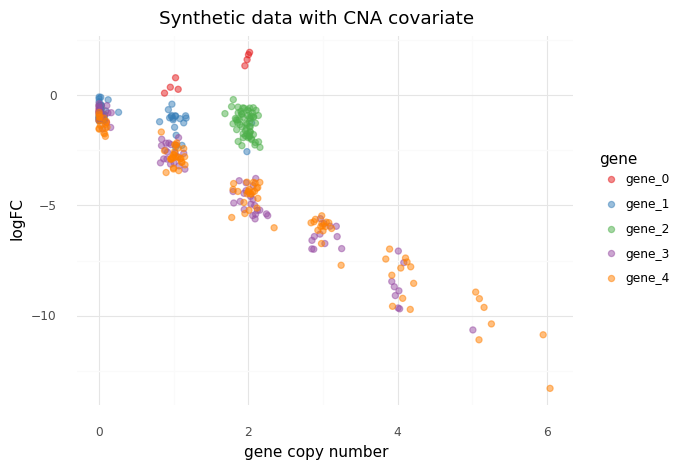

<ggplot: (8749579222559)>

In [82]:
(
    gg.ggplot(data, gg.aes(x="cna", y="logfc"))
    + gg.geom_jitter(gg.aes(color="gene"), alpha=0.5, size=2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(
        x="gene copy number",
        y="logFC",
        color="gene",
        title="Synthetic data with CNA covariate",
    )
)

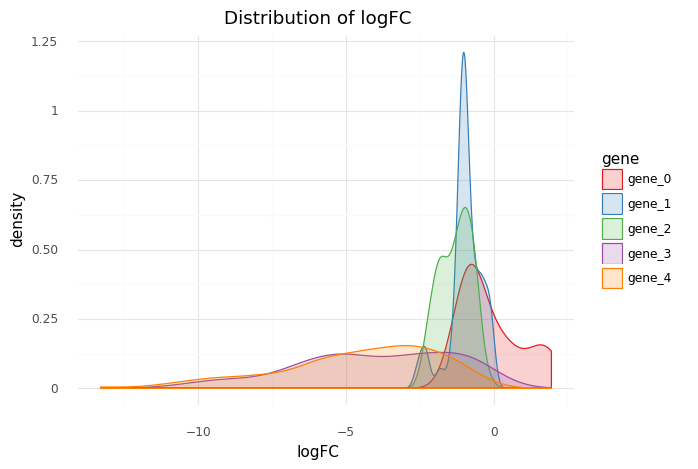

<ggplot: (8749579178234)>

In [83]:
(
    gg.ggplot(data, gg.aes(x="logfc"))
    + gg.geom_density(gg.aes(color="gene", fill="gene"), alpha=0.2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.labs(x="logFC", y="density", color="gene", title="Distribution of logFC")
)

In [84]:
sgrna_idx = data["sgRNA"].cat.codes.to_list()
sgrna_to_gene_idx = gene_to_sgrna_map["gene"].cat.codes.to_list()


with pm.Model() as model6:
    # Hyper-priors
    mu_gamma = pm.Normal("mu_gamma", -1, 5)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    mu_delta = pm.Normal("mu_delta", -1, 5)
    sigma_delta = pm.Exponential("sigma_delta", 1)

    # Hyper parameters
    gamma_g = pm.Normal("gamma_g", mu_gamma, sigma_gamma, shape=num_genes)
    mu_alpha = gamma_g
    sigma_alpha = pm.Exponential("sigma_alpha", 1)

    delta_g = pm.Normal("delta_g", mu_delta, sigma_delta, shape=num_genes)
    mu_beta = delta_g
    sigma_beta = pm.Exponential("sigma_beta", 1)

    # Main level parameters
    alpha_s = pm.Normal(
        "alpha_s", mu_alpha[sgrna_to_gene_idx], sigma_alpha, shape=num_sgrnas
    )
    beta_s = pm.Normal(
        "beta_s", mu_beta[sgrna_to_gene_idx], sigma_beta, shape=num_sgrnas
    )

    # Linear model
    mu_s = pm.Deterministic(
        "mu_s", alpha_s[sgrna_idx] + beta_s[sgrna_idx] * data.cna.values
    )
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    logfc = pm.Normal("logfc", mu_s, sigma, observed=data.logfc.values)

    # Sampling
    model6_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model6_trace = pm.sample(
        2000, tune=2000, random_seed=RANDOM_SEED, target_accept=0.95
    )
    model6_post_check = pm.sample_posterior_predictive(
        model6_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_s, alpha_s, sigma_beta, delta_g, sigma_alpha, gamma_g, sigma_delta, mu_delta, sigma_gamma, mu_gamma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 93 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


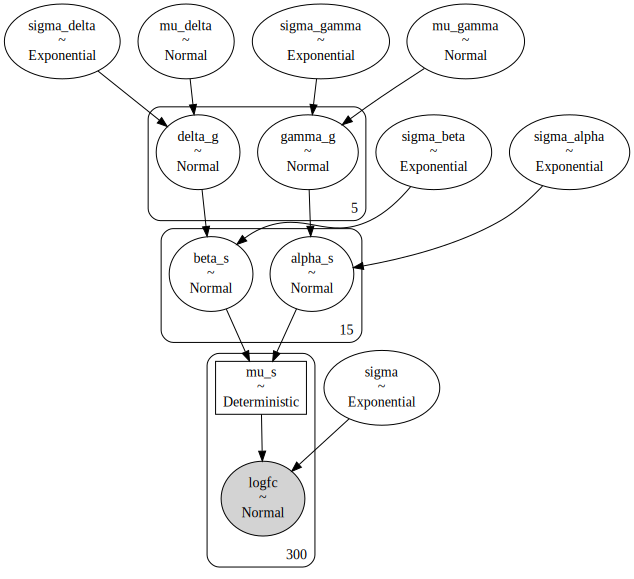

In [85]:
pm.model_to_graphviz(model6)

In [86]:
az_model6 = az.from_pymc3(
    trace=model6_trace,
    prior=model6_prior_check,
    posterior_predictive=model6_post_check,
    model=model6,
)

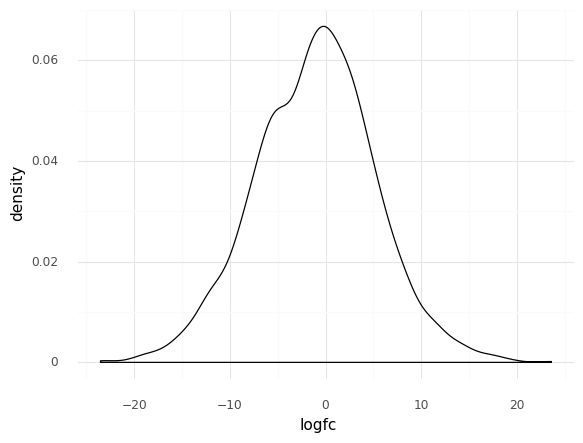

<ggplot: (8749580521771)>

In [87]:
(
    gg.ggplot(
        pd.DataFrame({"logfc": model6_prior_check["logfc"][:, 1:5].flatten()}),
        gg.aes(x="logfc"),
    )
    + gg.geom_density()
)

In [88]:
az.summary(az_model6, var_names=["gamma_g"]).assign(real_value=real_params["gamma_g"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_value
gamma_g[0],-0.824,0.161,-1.113,-0.494,0.002,0.001,7105.0,6900.0,7237.0,4828.0,1.0,-1.124639
gamma_g[1],-0.671,0.140,-0.954,-0.420,0.002,0.002,3951.0,3857.0,3977.0,4753.0,1.0,-0.630166
gamma_g[2],-0.625,0.390,-1.246,0.175,0.011,0.008,1352.0,1352.0,1712.0,1328.0,1.0,-0.308103
gamma_g[3],-0.793,0.101,-0.984,-0.607,0.001,0.001,5569.0,5473.0,5559.0,4803.0,1.0,-0.692731
gamma_g[4],-1.060,0.103,-1.237,-0.849,0.002,0.001,3828.0,3828.0,3944.0,4100.0,1.0,-1.042568


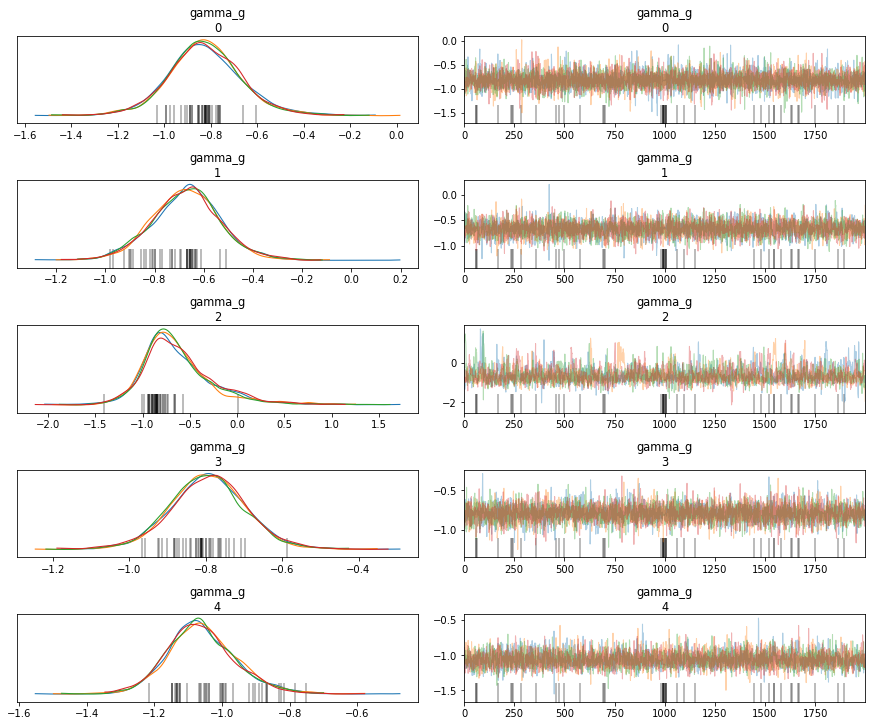

In [89]:
az.plot_trace(az_model6, var_names=["gamma_g"])
plt.show()

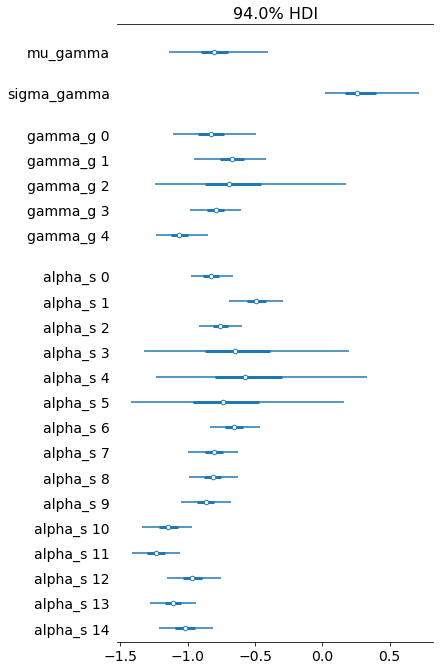

In [90]:
var_names = ["mu_gamma", "sigma_gamma", "gamma_g", "alpha_s"]
az.plot_forest(
    az_model6, var_names=var_names, combined=True,
)
plt.show()

In [91]:
az.summary(az_model6, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_gamma,-0.791,0.202,-1.142,-0.405,0.004,0.003,2878.0,2878.0,3457.0,2629.0,1.0
sigma_gamma,0.319,0.234,0.017,0.716,0.006,0.004,1565.0,1565.0,1604.0,1798.0,1.0
gamma_g[0],-0.824,0.161,-1.113,-0.494,0.002,0.001,7105.0,6900.0,7237.0,4828.0,1.0
gamma_g[1],-0.671,0.140,-0.954,-0.420,0.002,0.002,3951.0,3857.0,3977.0,4753.0,1.0
gamma_g[2],-0.625,0.390,-1.246,0.175,0.011,0.008,1352.0,1352.0,1712.0,1328.0,1.0
gamma_g[3],-0.793,0.101,-0.984,-0.607,0.001,0.001,5569.0,5473.0,5559.0,4803.0,1.0
gamma_g[4],-1.060,0.103,-1.237,-0.849,0.002,0.001,3828.0,3828.0,3944.0,4100.0,1.0
alpha_s[0],-0.827,0.084,-0.979,-0.665,0.001,0.001,8192.0,8068.0,8203.0,6278.0,1.0
alpha_s[1],-0.490,0.107,-0.696,-0.296,0.002,0.001,4244.0,4132.0,4238.0,5308.0,1.0
alpha_s[2],-0.759,0.085,-0.917,-0.599,0.001,0.001,5286.0,5273.0,5290.0,6116.0,1.0


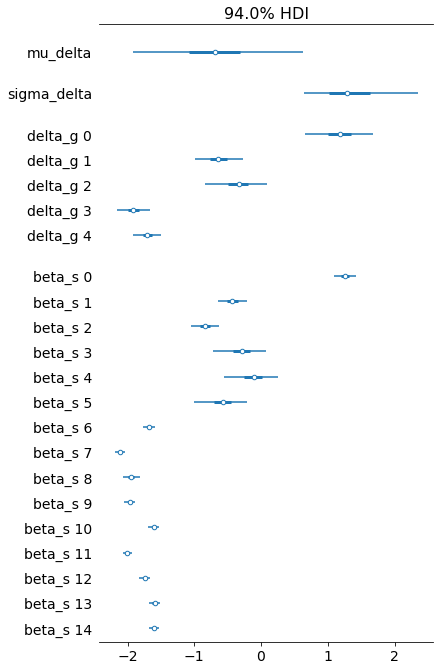

In [92]:
az.plot_forest(
    az_model6, var_names=["mu_delta", "sigma_delta", "delta_g", "beta_s"], combined=True
)
plt.show()

---

In [29]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

pymc3    3.9.3
plotnine 0.7.1
seaborn  0.11.0
pandas   1.1.3
arviz    0.10.0
numpy    1.19.2
last updated: 2020-10-26 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-237.o2.rc.hms.harvard.edu
Git branch : models
